In [ ]:
!pip install yfinance 

In [1]:
# Import des librairies
import numpy as np 
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [ ]:
# Collecte des données S&P 500
sp500 = yf.download('^GSPC', start='2022-01-01', end='2023-01-01')['Close']

In [3]:
# Chargement des données
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['Date'])


In [10]:
df = df.sort_values('Date')

In [11]:
#Visualisation du dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [12]:
#Nos interets se portent sur les colonnes Date et Close donc on laisse tomber le reste
df = df.drop(['Open', 'Adj Close', 'High', 'Volume', 'Low'], axis = 1) 
df.head() #Visualisation du dataframe

,Date,Close
0,1986-01-02,209.589996
1,1986-01-03,210.880005
2,1986-01-06,210.649994
3,1986-01-07,213.800003
4,1986-01-08,207.970001


In [4]:
# Préparation des données
data = df[['Date', 'Close']].set_index('Date')
scaler = MinMaxScaler()
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [5]:
# Entrainement du modèle Isolation Forest
clf = IsolationForest(n_estimators=100, contamination=0.05) 
clf.fit(data[['Scaled_Close']])

IsolationForest(contamination=0.05)

In [6]:
# Prédiction des anomalies 
scores = clf.decision_function(data[['Scaled_Close']])
data['Anomaly'] = clf.predict(data[['Scaled_Close']])

In [7]:
# Identification des anomalies  
anomalies = data.loc[data['Anomaly'] == -1]

<Figure size 720x432 with 0 Axes>

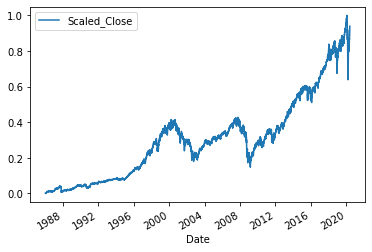

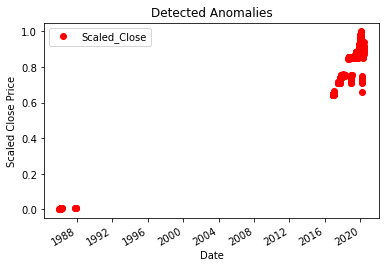

In [8]:
# Tracé des résultats
plt.figure(figsize=(10,6))
data[['Scaled_Close']].plot()
anomalies[['Scaled_Close']].plot(style='ro')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.title('Detected Anomalies')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


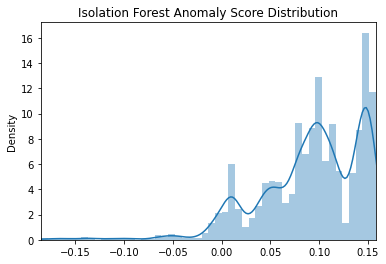

In [9]:
sns.distplot(scores, bins=50, kde=True)
plt.xlim([min(scores), max(scores)])  
plt.title("Isolation Forest Anomaly Score Distribution")
plt.show()

### Approche statistique

In [13]:
close_prices = df['Close'].values

In [14]:
mean = np.mean(close_prices)
std = np.std(close_prices)

In [15]:
anomalies = []
for i in range(len(close_prices)):
  if (close_prices[i] > mean + 2*std) or (close_prices[i] < mean - 2*std): 
    anomalies.append(i)

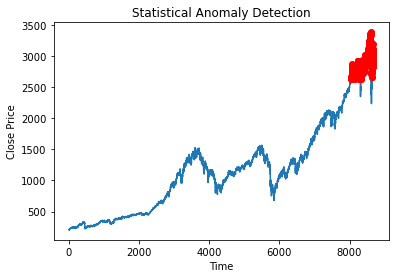

In [16]:
plt.plot(close_prices)
plt.plot(anomalies, close_prices[anomalies], 'ro')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Statistical Anomaly Detection')
plt.show()

### Détection par clustering K-Means

In [17]:
from sklearn.cluster import KMeans

In [18]:
model = KMeans(n_clusters=10) 
model.fit(close_prices.reshape(-1,1))

KMeans(n_clusters=10)

In [19]:
clusters = model.labels_ 
anomalies = []

In [20]:
for i in range(len(clusters)):
  if clusters[i] == -1: 
    anomalies.append(i)

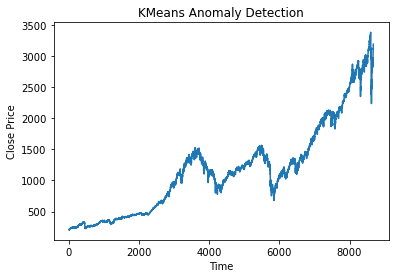

In [21]:
plt.plot(close_prices)
plt.plot(anomalies, close_prices[anomalies], 'ro') 
plt.title("KMeans Anomaly Detection")
plt.xlabel('Time') 
plt.ylabel('Close Price')
plt.show()

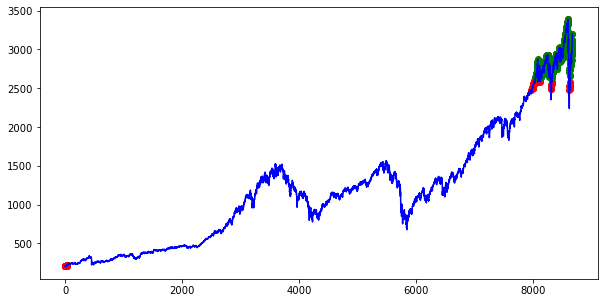

In [24]:
# Isolation Forest
iforest = IsolationForest(n_estimators=100)
iforest.fit(close_prices.reshape(-1,1))
iforest_scores = iforest.decision_function(close_prices.reshape(-1,1))
iforest_anomalies = np.where(iforest_scores < -0.1)

# Statistique  
mean = np.mean(close_prices)
std = np.std(close_prices)
stat_anomalies = np.where((close_prices > mean + 2*std) |  
                          (close_prices < mean - 2*std))

# KMeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(close_prices.reshape(-1,1))
clusters = kmeans.labels_
kmeans_anomalies = np.where(clusters == -1)

# Tracé
plt.figure(figsize=(10,5))
plt.plot(close_prices, color='blue') 

plt.scatter(iforest_anomalies, close_prices[iforest_anomalies], 
            color='red', label='Isolation Forest')
plt.scatter(stat_anomalies, close_prices[stat_anomalies],
           color='green', label='Statistical') 
plt.scatter(kmeans_anomalies, close_prices[kmeans_anomalies],
            color='orange', label='KMeans')

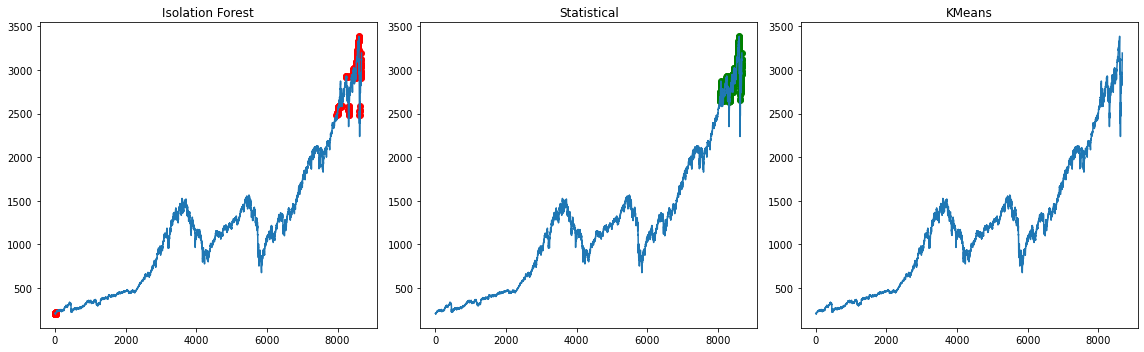

In [25]:
import matplotlib.pyplot as plt

# Figure avec 3 subplot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Isolation Forest
ax1.plot(close_prices)  
ax1.scatter(iforest_anomalies, close_prices[iforest_anomalies], color='red')
ax1.set_title('Isolation Forest')

# Statistique
ax2.plot(close_prices)   
ax2.scatter(stat_anomalies, close_prices[stat_anomalies], color='green') 
ax2.set_title('Statistical')

# KMeans
ax3.plot(close_prices)
ax3.scatter(kmeans_anomalies, close_prices[kmeans_anomalies], color='orange')  
ax3.set_title('KMeans')

# Affichage
fig.tight_layout()
plt.show()

NameError: name 'sp500' is not defined

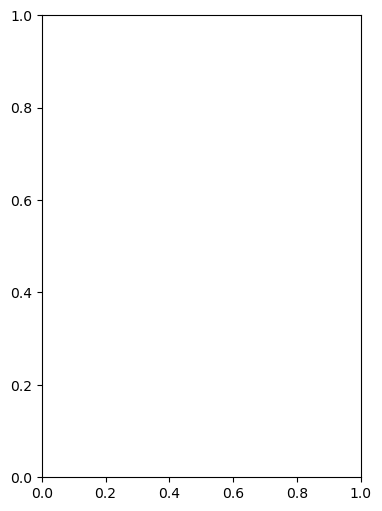

In [3]:
# Affichage des résultats par paire

# Graphique 1 - S&P 500 Close Price avec Anomalies Statistiques
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(sp500.index, sp500, label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.subplot(1, 3, 2)
plt.plot(sp500.index, sp500, label='S&P 500 Close Price', color='blue')
plt.scatter(sp500[sp500_anomaly_stat].index, sp500[sp500_anomaly_stat], label='Anomaly (Stat)', color='red', s=50)
plt.title('Anomalies (Statistique)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.subplot(1, 3, 3)
plt.plot(sp500.index, sp500, label='S&P 500 Close Price', color='blue')
plt.scatter(sp500[sp500_anomaly_iso == -1].index, sp500[sp500_anomaly_iso == -1], label='Anomaly (Iso)', color='green', s=50)
plt.title('Anomalies Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()
